# Постановка задачи

**Тема**: Анализ производительности алгоритмов решения задач достижимости.

**Цель**: Исследовать эффективность алгоритмов для различных вариантов представления разреженных матриц и векторов, а также определить оптимальный размер стартового множества для достижения наилучшей производительности.

**Задачи**:
1. Выбор оптимального для решения задачи представления разреженных матриц и векторов.
2. Определение оптимального размера множества стартовых вершин.

# Описание решений
В рамках задачи будут исследованы два алгоритма решения задач достижимости: 
## Tensor based RPQ
Получает на вход граф, набор стартовых и конечных вершин, а также регулярное выражение. Строит конечные автоматы по графу и регулярному выражению. Затем с помощью транзитивного замыкания находит матрицу смежности, через которую и проверяется достижимость в полученном при пересечении автомате.
## Multiple source BFS based RPQ
Получает на вход граф, набор стартовых и конечных вершин, а также регулярное выражение. Определяет достижимость через обход в ширину, основанный на линейной алгебре. Автомат графа и регулярного выражения одновременно обходятся, фронт записывает в виде матрицы, куда последовательно добавляются значения. Каждый обход -- это перемножение этой матрицы и матрицы смежности. Когда процесс обхода завершается (фронт становится пустым), нужные пары стартовых и конечных вершин достаются из специальной матрицы со всеми посещёнными состояниями.

# Набор данных
## Графы
- Граф [skos](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/graphs/data/skos.html#skos) имеет наименьшее число вершин и рёбер, относительно других графов из набора. Он был выбран, так как алгоритмам не требуется большого количества времени на его обработку.
- Граф [wc](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/graphs/data/wc.html#wc) содержит большее количество вершин и рёбер, чем skos и при этом не заставляет алгоритмы отрабатывать слишком большое количество времени. Был выбран, чтобы убедиться, что результаты корректны и для большего числа вершин.
## Запросы
Были выбраны так, чтобы охватить все общепринятые конструкции регулярных выражений:
- 'x y x'
- 'x* y*'
- '(x | y)*'
- x* | y*

In [2]:
from grapher import GraphData
import cfpq_data

graphs = {"skos": GraphData("skos"), "wc": GraphData("wc")}

regexes: list[str] = {
    "skos": ["type label type", "type* label*", "(type|label)*", "type*|label*"],
    "wc": ["a d a", "a* d*", "(a|d)*", "a*|d*"],
}

[2024-11-01 18:02:59]>INFO>Found graph with name='skos'
[2024-11-01 18:02:59]>INFO>Load archive graph_archive=PosixPath('/home/dmitriy/dev/formal-languages/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/skos.tar.gz')
[2024-11-01 18:02:59]>INFO>Unzip graph name='skos' to file graph=PosixPath('/home/dmitriy/dev/formal-languages/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/skos/skos.csv')
[2024-11-01 18:02:59]>INFO>Remove archive graph_archive=PosixPath('/home/dmitriy/dev/formal-languages/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/skos.tar.gz')
[2024-11-01 18:02:59]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f40c6260d10> from path=PosixPath('/home/dmitriy/dev/formal-languages/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/skos/skos.csv')
[2024-11-01 18:02:59]>INFO>Construct labels_frequency=defaultdict(<class 'int'>, {'subPropertyOf': 24, 'label': 32, 'comment': 13, 'definition': 32, 'isDefinedBy': 32, 'type': 70,

# Эксперименты
## Оборудование
- **OS**: Ubuntu 24.04.1 LTS on Windows 10 x86_64
- **CPU**: 11th Gen Intel i7-1165G7 (8) @ 2.803GHz
- **Memory**: 16 GB, 3200 MT/s, 2 slots

## Измерения
В ходе экспериментов отслеживались следующие параметры:
- Тип алгоритма
- Тип графа
- Регулярное выражение
- Размер множества начальных вершин
- Тип матриц и векторов
- Время выполнения на этих данных (в долях секунды)

Сначала был произведён запуск алгоритмов на всех графах и регулярных выражениях, но с разными представлениями разреженных матриц и векторов. Набор стартовых и конечных вершин определялся случайно для каждого графа и регекса (но всегда был одного размера). На каждом наборе данных каждый алгоритм отрабатывал по несколько раз, в таблицу добавлялось среднее время работы за все запуски. Этот эксперимент должен был показать, какое представление наиболее эффективно для каждого из алгоритмов.

Затем, используя оптимальное представление разреженных матриц и векторов, для каждого типа графа и регулярного выражения было случайно выбрано множество стартовых вершин, размером 5%, 10%, 15%, 20%, 25%, 30%, 40% и 50% от общего числа вершин в графе. Алгоритмы также запускались несколько раз на одих и тех же данных, в таблицу с результатами добавлялось среднее время работы алгоритма. С помощью этого эксперимента предполагалось ответь на вопрос, как производительность (время работы) алгоритмов зависит от размера множества стартовых вершин.

In [3]:
# dok, lil
import random
import time
from task5 import tensor_based_rpq
from scipy.sparse import (
    dok_array,
    lil_array,
    dok_matrix,
    lil_matrix,
)
import numpy as np

graph = graphs["skos"].graph
regex = regexes["skos"][0]

start_nodes_count = int(0.05 * len(graph.nodes))

start_nodes = cfpq_data.generate_multiple_source(graph, start_nodes_count)
end_nodes = random.sample(list(start_nodes), random.randint(1, start_nodes_count))

res = []

for i in range(3):
    t_start = time.perf_counter()
    tensor_based_rpq(
        regex,
        graph,
        start_nodes,
        end_nodes,
        dok_array,
        "dok",
    )
    t_end = time.perf_counter()

    res.append(t_end - t_start)

print(np.mean(res))

[2024-11-01 18:02:59]>INFO>Generate set of source vertices of 7 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f40c6260d10> for multiple-source evaluation


64.529096825


In [4]:
from task5 import ms_bfs_based_rpq, tensor_based_rpq
from scipy.sparse import (
    coo_array,
    csr_array,
    csc_array,
    dok_array,
    coo_matrix,
    csr_matrix,
    csc_matrix,
)
import time
import pandas as pd
import random
from scipy import stats

results = {
    "Algo": [],
    "Graph Name": [],
    "Regex": [],
    "Start Nodes": [],
    "Mean Time": [],
    "Data Type": [],
    "Std Dev": [],
    "CI Lower": [],
    "CI Upper": [],
}

sparse_types = [
    ("coo", coo_array, coo_matrix),
    ("csr", csr_array, csr_matrix),
    ("csc", csc_array, csc_matrix),
    ("dok", dok_array, dok_matrix),
    ("lil", lil_array, lil_matrix),
]

repeat_times = 20

# for every graph
for graph_name in graphs.keys():
    graph = graphs[graph_name].graph

    # for every regex
    for regex in regexes[graph_name]:
        # 5% of the number of nodes
        start_nodes_count = int(0.05 * len(graph.nodes))

        start_nodes = cfpq_data.generate_multiple_source(graph, start_nodes_count)
        end_nodes = random.sample(
            list(start_nodes), random.randint(1, start_nodes_count)
        )

        # for every array/matrix type
        for sparse_type in sparse_types:
            tensor_time = []
            bfs_time = []

            # repeat several times
            for i in range(repeat_times):
                if sparse_type[0] not in ["dok"]:
                    t_start = time.perf_counter()
                    tensor_based_rpq(
                        regex,
                        graph,
                        start_nodes,
                        end_nodes,
                        sparse_type[1],
                        sparse_type[0],
                    )
                    t_end = time.perf_counter()

                    tensor_time.append(t_end - t_start)
                else:
                    tensor_time.append(0)

                t_start = time.perf_counter()
                ms_bfs_based_rpq(
                    regex, graph, start_nodes, end_nodes, sparse_type[2], sparse_type[1]
                )
                t_end = time.perf_counter()

                bfs_time.append(t_end - t_start)

            tensor_ci95 = stats.t.ppf(0.975, df=len(tensor_time) - 1) * stats.sem(
                tensor_time
            )
            bfs_ci95 = stats.t.ppf(0.975, df=len(bfs_time) - 1) * stats.sem(bfs_time)

            tensor_mean = np.mean(tensor_time)
            bfs_mean = np.mean(bfs_time)

            results["Algo"].append("Tensor Based RPQ")
            results["Graph Name"].append(graph_name)
            results["Regex"].append(regex)
            results["Start Nodes"].append("5%")
            results["Mean Time"].append(tensor_mean)
            results["Data Type"].append(sparse_type[0])
            results["Std Dev"].append(np.std(tensor_time, ddof=1))
            results["CI Lower"].append(tensor_mean - tensor_ci95)
            results["CI Upper"].append(tensor_mean + tensor_ci95)

            results["Algo"].append("MS-BFS Based RPQ")
            results["Graph Name"].append(graph_name)
            results["Regex"].append(regex)
            results["Start Nodes"].append("5%")
            results["Mean Time"].append(bfs_mean)
            results["Data Type"].append(sparse_type[0])
            results["Std Dev"].append(np.std(bfs_time, ddof=1))
            results["CI Lower"].append(bfs_mean - bfs_ci95)
            results["CI Upper"].append(bfs_mean + bfs_ci95)

df_1 = pd.DataFrame(data=results)

[2024-11-01 18:06:17]>INFO>Generate set of source vertices of 7 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f40c6260d10> for multiple-source evaluation
/home/dmitriy/dev/formal-languages/.venv/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/home/dmitriy/dev/formal-languages/.venv/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray_sparse(i, j, x)
[2024-11-01 18:06:26]>INFO>Generate set of source vertices of 7 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f40c6260d10> for multiple-source evaluation
[2024-11-01 18:06:30]>INFO>Generate set of source vertices of 7 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph 

In [5]:
from task5 import ms_bfs_based_rpq, tensor_based_rpq
import time
import pandas as pd
import random

results = {
    "Algo": [],
    "Graph Name": [],
    "Regex": [],
    "Start Nodes": [],
    "Mean Time": [],
    "Data Type": [],
    "Std Dev": [],
    "CI Upper": [],
    "CI Lower": [],
}

repeat_times = 200

# for every graph
for graph_name in graphs.keys():
    graph = graphs[graph_name].graph

    # for every regex
    for regex in regexes:
        procs = [
            0.05,
            0.1,
            0.15,
            0.2,
            0.25,
            0.3,
            0.4,
            0.5,
        ]  # percentage of the number of nodes

        # for every start nodes size
        for proc in procs:
            start_nodes_count = int(proc * len(graph.nodes))

            start_nodes = cfpq_data.generate_multiple_source(graph, start_nodes_count)
            end_nodes = random.sample(
                list(start_nodes), random.randint(1, start_nodes_count)
            )

            tensor_time = []
            bfs_time = []

            for i in range(repeat_times):
                t_start = time.perf_counter()
                tensor_based_rpq(regex, graph, start_nodes, end_nodes, csr_array, "csr")
                t_end = time.perf_counter()

                tensor_time.append(t_end - t_start)

                t_start = time.perf_counter()
                ms_bfs_based_rpq(
                    regex, graph, start_nodes, end_nodes, csr_matrix, csr_array
                )
                t_end = time.perf_counter()

                bfs_time.append(t_end - t_start)

            tensor_ci95 = stats.t.ppf(0.975, df=len(tensor_time) - 1) * stats.sem(
                tensor_time
            )
            bfs_ci95 = stats.t.ppf(0.975, df=len(bfs_time) - 1) * stats.sem(bfs_time)

            tensor_mean = np.mean(tensor_time)
            bfs_mean = np.mean(bfs_time)

            results["Algo"].append("Tensor Based RPQ")
            results["Graph Name"].append(graph_name)
            results["Regex"].append(regex)
            results["Start Nodes"].append(f"{int(proc * 100)}%")
            results["Mean Time"].append(tensor_mean)
            results["Data Type"].append("csr")
            results["Std Dev"].append(np.std(tensor_time, ddof=1))
            results["CI Lower"].append(tensor_mean - tensor_ci95)
            results["CI Upper"].append(tensor_mean + tensor_ci95)

            results["Algo"].append("MS-BFS Based RPQ")
            results["Graph Name"].append(graph_name)
            results["Regex"].append(regex)
            results["Start Nodes"].append(f"{int(proc * 100)}%")
            results["Mean Time"].append(bfs_mean)
            results["Data Type"].append("csr")
            results["Std Dev"].append(np.std(bfs_time, ddof=1))
            results["CI Lower"].append(bfs_mean - bfs_ci95)
            results["CI Upper"].append(bfs_mean + bfs_ci95)

df_2 = pd.DataFrame(data=results)

[2024-11-01 18:18:04]>INFO>Generate set of source vertices of 7 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f40c6260d10> for multiple-source evaluation


[2024-11-01 18:18:07]>INFO>Generate set of source vertices of 14 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f40c6260d10> for multiple-source evaluation
[2024-11-01 18:18:11]>INFO>Generate set of source vertices of 21 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f40c6260d10> for multiple-source evaluation
[2024-11-01 18:18:16]>INFO>Generate set of source vertices of 28 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f40c6260d10> for multiple-source evaluation
[2024-11-01 18:18:19]>INFO>Generate set of source vertices of 36 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f40c6260d10> for multiple-source evaluation
[2024-11-01 18:18:26]>INFO>Generate set of source vertices of 43 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f40c6260d10> for multiple-source evaluation
[2024-11-01 18:18:32]>INFO>Generate set of source vertices of 57 nodes for graph=<networkx

# Результаты
Исходя из полученных данных, для алгоритма MS-BFS Based RPQ, наиболее удачными являются представления *coo_array/coo_matrix* и *csr_matrix/csr_array*, так как время работы алгоритма в обоих этих случаях было минимальным.

Для алгоритма Tensor Based RPQ, *dok_array/dok_matrix* показал слишком большое время работы (более одной минуты на один запуск), так что он не представлен в таблице результатов. Оптимальными представлениями оказались *csc_array/csc_matrix* и *csr_array/csr_matrix*, время работы с ними было приблизительно одинаковым.

При анализе графиков, полученных при запусках алгоритмов на наборах начальных вершин разных размеров, отчётливо видно, что MS-BFS Based RPQ не так сильно зависит от размера множества начальных вершин, как Tensor Based RPQ, ведь его время работы почти не менялось. Также удалось установить, что Tensor Based RPQ при любом размере множества стартовых вершин менее эффективен, чем MS-BFS Based RPQ. При размере множества 10% от общего размера множества вершин графа, Tensor Based RPQ начинает сильно проигрывать в скорости работы. Предположительно, малая эффективность этого алгоритма связана с тем, что его скорость сходимости сильно зависит от множеств стартовых/конечных вершин и при увеличении их размеров количество операций так же возрастает.

Data Type
coo    0.024855
csc    0.025838
csr    0.025226
dok    0.032094
lil    0.033631
Name: Mean Time, dtype: float64

Data Type
coo    1.007650
csc    1.117006
csr    1.020755
dok    0.000000
lil    1.021076
Name: Mean Time, dtype: float64

,Algo,Data Type,Mean Time
0,MS-BFS Based RPQ,coo,0.024855
1,MS-BFS Based RPQ,csc,0.025838
2,MS-BFS Based RPQ,csr,0.025226
3,MS-BFS Based RPQ,dok,0.032094
4,MS-BFS Based RPQ,lil,0.033631
5,Tensor Based RPQ,coo,1.007650
6,Tensor Based RPQ,csc,1.117006
7,Tensor Based RPQ,csr,1.020755
8,Tensor Based RPQ,dok,0.000000
9,Tensor Based RPQ,lil,1.021076


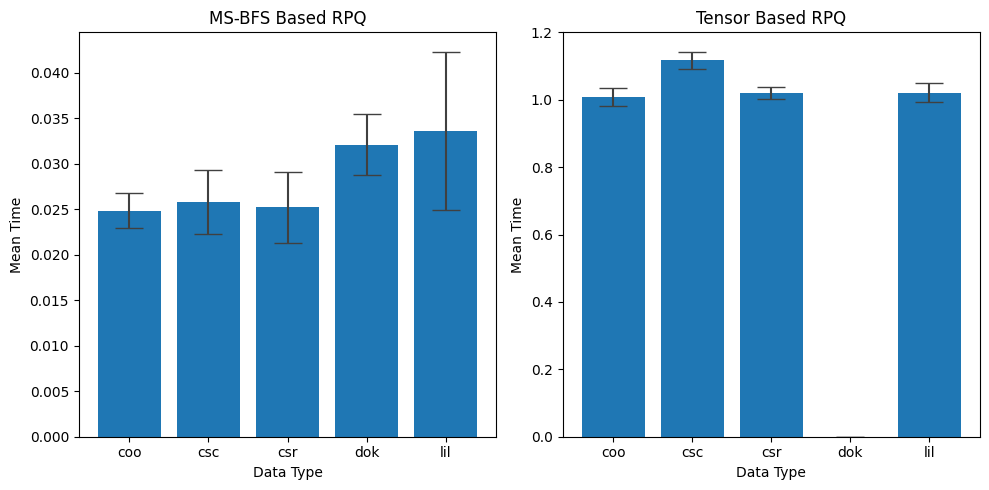

In [ ]:
import matplotlib.pyplot as plt

average_times = df_1.groupby(["Algo", "Data Type"])["Mean Time"].mean().reset_index()
std_dev = df_1.groupby(["Algo", "Data Type"])["Std Dev"].mean().reset_index()

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for i, algo in enumerate(average_times["Algo"].unique()):
    # for current algo
    algo_mean_time = average_times[average_times["Algo"] == algo]
    algo_std_dev = std_dev[std_dev["Algo"] == algo]

    # grouped by data type
    grouped_mean_time = algo_mean_time.groupby("Data Type")["Mean Time"].mean()
    grouped_std_dev = algo_std_dev.groupby("Data Type")["Std Dev"].mean()

    axes[i].bar(
        grouped_mean_time.index,
        grouped_mean_time.values,
        yerr=grouped_std_dev.values,
        error_kw={"ecolor": "0.25", "capsize": 10},
    )

    axes[i].set_title(f"{algo}")
    axes[i].set_xlabel("Data Type")
    axes[i].set_ylabel("Mean Time")

display(average_times)
plt.tight_layout()
plt.show()

/tmp/ipykernel_1008/3002216792.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  res[algo] = (grouped_mean_time[0], grouped_mean_time[1], grouped_mean_time[2], grouped_mean_time[3], grouped_mean_time[4])
/tmp/ipykernel_1008/3002216792.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  res[algo] = (grouped_mean_time[0], grouped_mean_time[1], grouped_mean_time[2], grouped_mean_time[3], grouped_mean_time[4])


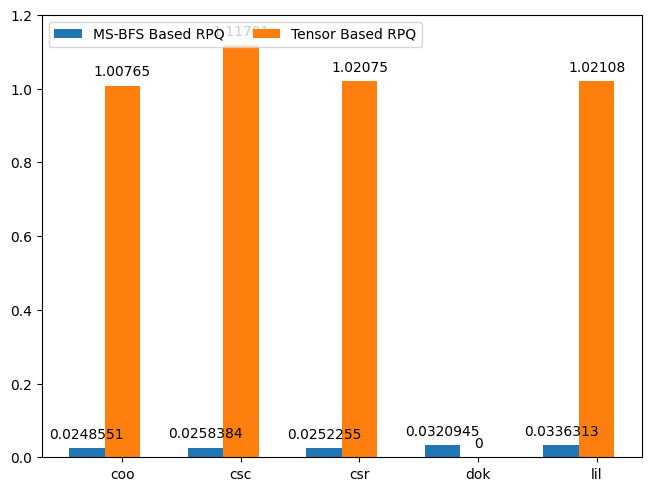

In [66]:
import matplotlib.pyplot as plt

average_times = df_1.groupby(["Algo", "Data Type"])["Mean Time"].mean().reset_index()

types = ("coo", "csc", "csr", "dok", "lil")

res = {}

for i, algo in enumerate(average_times["Algo"].unique()):
    algo_mean_time = average_times[average_times["Algo"] == algo]
    grouped_mean_time = algo_mean_time.groupby("Data Type")["Mean Time"].mean()

    res[algo] = (
        grouped_mean_time[0],
        grouped_mean_time[1],
        grouped_mean_time[2],
        grouped_mean_time[3],
        grouped_mean_time[4],
    )

fig, ax = plt.subplots(layout="constrained")

width = 0.3  # Adjust width as needed

# Create x positions for each data type
x_pos = range(len(types))

multiplier = 0

for attribute, measurement in res.items():
    offset = width * multiplier  # Calculate offset for each algorithm
    rects = ax.bar([x + offset for x in x_pos], measurement, width, label=attribute)
    ax.bar_label(rects, padding=5)
    multiplier += 1

ax.legend(loc="upper left", ncols=5)
ax.set_xticks([x + width for x in x_pos])  # Set x ticks at the center of each bar group
ax.set_xticklabels(types)  # Set tick labels with data types
ax.set_ylim(0, 1.2)

plt.show()

,Algo,Start Nodes,Mean Time
0,MS-BFS Based RPQ,10%,0.013220
1,MS-BFS Based RPQ,15%,0.012571
2,MS-BFS Based RPQ,20%,0.012162
3,MS-BFS Based RPQ,25%,0.012776
4,MS-BFS Based RPQ,30%,0.012150
5,MS-BFS Based RPQ,40%,0.013161
6,MS-BFS Based RPQ,5%,0.011304
7,MS-BFS Based RPQ,50%,0.013414
8,Tensor Based RPQ,10%,0.020775
9,Tensor Based RPQ,15%,0.044867


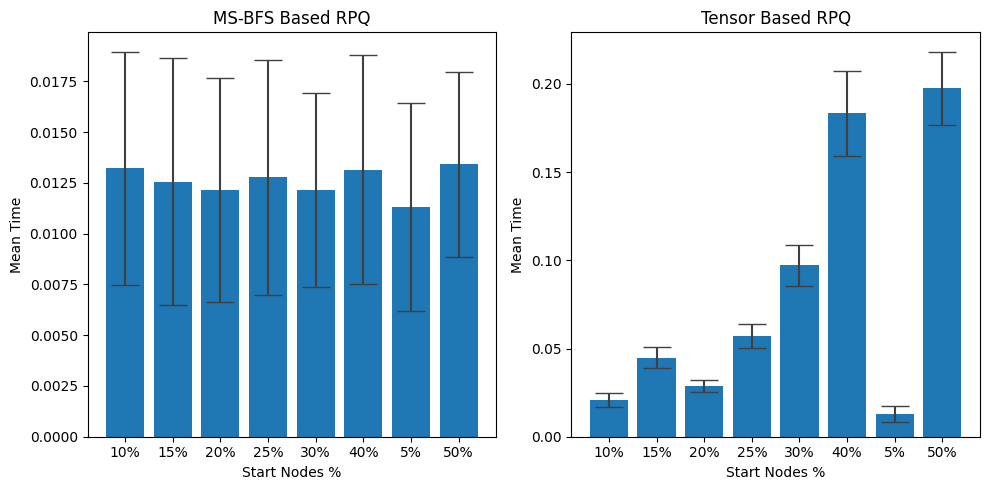

In [8]:
import matplotlib.pyplot as plt

average_times = df_2.groupby(["Algo", "Start Nodes"])["Mean Time"].mean().reset_index()
std_dev = df_2.groupby(["Algo", "Start Nodes"])["Std Dev"].mean().reset_index()

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for i, algo in enumerate(average_times["Algo"].unique()):
    # for every algo
    algo_mean_time = average_times[average_times["Algo"] == algo]
    algo_std_dev = std_dev[std_dev["Algo"] == algo]

    # grouped by start nodes
    grouped_mean_time = algo_mean_time.groupby("Start Nodes")["Mean Time"].mean()
    grouped_std_dev = algo_std_dev.groupby("Start Nodes")["Std Dev"].mean()

    axes[i].bar(
        grouped_mean_time.index,
        grouped_mean_time.values,
        yerr=grouped_std_dev.values,
        error_kw={"ecolor": "0.25", "capsize": 10},
    )

    axes[i].set_title(f"{algo}")
    axes[i].set_xlabel("Start Nodes %")
    axes[i].set_ylabel("Mean Time")

display(average_times)
plt.tight_layout()
plt.show()

/tmp/ipykernel_1008/1592567493.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  res[algo] = (grouped_mean_time[0], grouped_mean_time[1], grouped_mean_time[2], grouped_mean_time[3], grouped_mean_time[4],
/tmp/ipykernel_1008/1592567493.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grouped_mean_time[5], grouped_mean_time[6], grouped_mean_time[7])
/tmp/ipykernel_1008/1592567493.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos

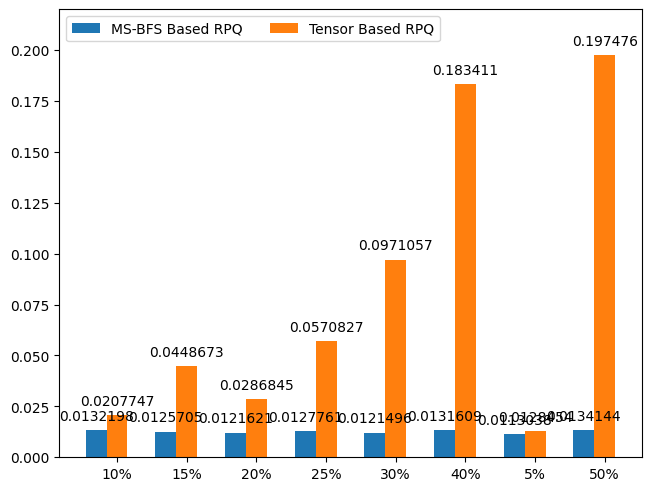

In [ ]:
import matplotlib.pyplot as plt

average_times = df_2.groupby(["Algo", "Start Nodes"])["Mean Time"].mean().reset_index()

types = ("10%", "15%", "20%", "25%", "30%", "40%", "5%", "50%")

res = {}

for i, algo in enumerate(average_times["Algo"].unique()):
    algo_mean_time = average_times[average_times["Algo"] == algo]
    grouped_mean_time = algo_mean_time.groupby("Start Nodes")["Mean Time"].mean()

    res[algo] = (
        grouped_mean_time[0],
        grouped_mean_time[1],
        grouped_mean_time[2],
        grouped_mean_time[3],
        grouped_mean_time[4],
        grouped_mean_time[5],
        grouped_mean_time[6],
        grouped_mean_time[7],
    )

fig, ax = plt.subplots(layout="constrained")

width = 0.3  # Adjust width as needed

# Create x positions for each data type
x_pos = range(len(types))

multiplier = 0

for attribute, measurement in res.items():
    offset = width * multiplier  # Calculate offset for each algorithm
    rects = ax.bar([x + offset for x in x_pos], measurement, width, label=attribute)
    ax.bar_label(rects, padding=5)
    multiplier += 1

ax.legend(loc="upper left", ncols=5)
ax.set_xticks([x + width for x in x_pos])  # Set x ticks at the center of each bar group
ax.set_xticklabels(types)  # Set tick labels with data types
ax.set_ylim(0, 0.22)

plt.show()